In [3]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap
from mazepy.basic._time_sync import _coordinate_recording_time

code_id = "0856 - Before Lap Neural Activity"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)
    
def get_neural_traj(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    
    neural_trajs = []
    route_trajs = []
    lap_trajs = []
    time_trajs = []

    for i in range(1, beg_idx.shape[0]):
        if trace['is_perfect'][i] != 1:
            continue
        
        spike_idx = np.where(
            (trace['ms_time'] > end_time[i-1]) & (trace['ms_time'] < beg_time[i])
        )[0]
        
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(np.ones(Spikes.shape[1], np.int64)),
        )
        
        neural_traj = spike_train.calc_neural_trajectory(500, 100)
        neural_traj_vec = neural_traj.to_array()
        time_traj = neural_traj.time
        
        neural_trajs.append(neural_traj_vec)
        dx, dy = np.ediff1d(trace['correct_pos'][:, 0]), np.ediff1d(trace['correct_pos'][:, 1])
        dt = np.ediff1d(trace['correct_time'])
        route_trajs.append(np.repeat(routes[i], neural_traj_vec.shape[1]).astype(np.int64))
        lap_trajs.append(np.repeat(i, neural_traj_vec.shape[1]).astype(np.int64))
        time_trajs.append(time_traj)
    
    return (
        np.concatenate(neural_trajs, axis=1), 
        np.concatenate(route_trajs), 
        np.concatenate(lap_trajs), 
        np.concatenate(time_trajs)
    )
    
def counts(traces, index_map):
    count_map = np.where(index_map > 0, 1, 0)
    sums = np.sum(count_map, axis=0)
    idx = np.where(sums == 7)[0]
    
    neural_trajs, route_trajs, lap_trajs, time_trajs = [], [], [], []
    session_trajs = []
    for i in range(len(traces)):
        neural_traj, route_traj, lap_traj, time_traj = get_neural_traj(traces[i])
        neural_trajs.append(neural_traj[index_map[i, idx]-1, :])
        route_trajs.append(route_traj)
        lap_trajs.append(lap_traj)
        session_trajs.append(np.repeat(i, len(lap_traj)))
        time_trajs.append(time_traj)
               
    neural_traj = np.concatenate(neural_trajs, axis=1)
    route_traj = np.concatenate(route_trajs)
    lap_traj = np.concatenate(lap_trajs)
    session_traj = np.concatenate(session_trajs)
    time_traj = np.concatenate(time_trajs)
    print(neural_traj.shape, session_traj.shape, route_traj.shape, lap_traj.shape, time_traj)
    
    with open(join(loc, f"{traces[0]['MiceID']}.pkl"), 'wb') as f:
        pickle.dump([
            neural_traj, 
            route_traj,
            lap_traj,
            session_traj, 
            time_traj
        ], f)

"""
if __name__ == '__main__':
    for m, mouse in enumerate([10212, 10224, 10227, 10232]):
        if 1:
            traces = []
            for i in np.where(f2['MiceID'] == mouse)[0]:
                with open(f2['Trace File'][i], 'rb') as handle:
                    trace = pickle.load(handle)
                traces.append(trace)

            with open(f_CellReg_dsp['cellreg_folder'][1+m], 'rb') as handle:
                index_map = pickle.load(handle)
            
                if mouse != 10232:
                    index_map = index_map[1:, :]
            
            _ = counts(traces, index_map.astype(np.int64))
"""
        

        E:\Data\FinalResults\Dsp\0856 - Before Lap Neural Activity is already existed!
(118, 90262) (90262,) (90262,) (90262,) [  89277.   89377.   89477. ... 4291160. 4291260. 4291360.]
(144, 123775) (123775,) (123775,) (123775,) [  44565.   44665.   44765. ... 3942034. 3942134. 3942234.]
(302, 66419) (66419,) (66419,) (66419,) [ 162519.  162619.  162719. ... 3874592. 3874692. 3874792.]
(261, 106476) (106476,) (106476,) (106476,) [  35269.   35369.   35469. ... 4080291. 4080391. 4080491.]


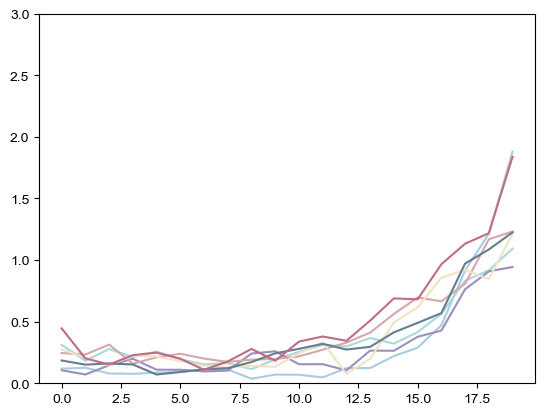

In [63]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC

dir_name2 = join(figpath, "Dsp", "0856 - Before Lap Neural Activity")
dir_name1 = join(figpath, "Dsp", "0850 - Lisa Paper Revisits")
dir_name0 = join(figpath, "Dsp", "0844 - Manifold of Initialization")

def get_transient_map(mouse: int):
    if exists(join(dir_name1, f"transient_{mouse}.pkl")):
        with open(join(dir_name1, f"transient_{mouse}.pkl"), "rb") as f:
            return pickle.load(f)
    else:
        raise FileNotFoundError(
            f"Please run Fig0850 - Lisa Paper Revisits.ipynb first "
            f"to generate transient_{mouse}.pkl"
        )

def get_map_identity(mouse, is_remove_first = False):
    (
        kmeans_dist_traj, 
        neural_traj, 
        session_traj, 
        old_pos_traj, 
        route_traj, 
        lap_traj, 
        pos_traj, 
        speed_traj,
        dists
    ) = get_transient_map(mouse)
    
    beg = np.concatenate([[0], np.where(np.ediff1d(lap_traj) != 0)[0]+1])
    end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0]+1, [lap_traj.shape[0]]])
    
    if is_remove_first:
        idx = np.where((lap_traj[beg]) != 0)[0]
        beg = beg[idx]
        end = end[idx]
    
    mean_kmeans_dist = np.zeros(beg.shape[0])
    for i in range(beg.shape[0]):
        mean_kmeans_dist[i] = np.nanmean(kmeans_dist_traj[beg[i]:end[i]])
    
    return mean_kmeans_dist

def cohen_ds(vals1, vals2):
    if len(vals1) < 3 or len(vals2) < 3:
        return np.nan
    
    s1, s2 = np.nanstd(vals1), np.nanstd(vals2)
    
    sp = np.sqrt((
        (len(vals1)-1) * s1**2 + (len(vals2)-1) * s2**2
    ) / (vals1.shape[0] + vals2.shape[0] - 2))
    
    return (np.nanmean(vals1) - np.nanmean(vals2)) / sp

def calc_discriminant_index(mat, route_traj):
    np.fill_diagonal(mat, np.nan)
    
    avg_mat = np.zeros(7)
    for i in range(7):
        idxi = np.where(route_traj == i)[0]
        idxj = np.where(route_traj != i)[0]
        ctrl_idx = np.ix_(idxi, idxj)
        comp_idx = np.ix_(idxi, idxi)
        vals1 = mat[comp_idx][np.triu_indices(idxi.shape[0], 1)]
        vals2 = mat[ctrl_idx].flatten()
        avg_mat[i] = cohen_ds(vals1, vals2)
            
    return avg_mat

def get_interlap_maps(mouse):
    with open(join(loc, f"{mouse}.pkl"), 'rb') as handle:
        (
            neural_traj, 
            route_traj,
            lap_traj,
            session_traj, 
            time_traj
        ) = pickle.load(handle)
        
    mean_dist = get_map_identity(mouse, is_remove_first=True)
    mean_dist = np.where(mean_dist > 0, 0, 1)
        
    end = np.concatenate([np.where(np.ediff1d(lap_traj) != 0)[0]+1, [lap_traj.shape[0]]])-1
    
    DI = np.zeros((20, 7))
    for i in range(DI.shape[0]):
        mat = np.mean(np.stack([
            np.corrcoef(neural_traj[:, end-i*5-j].T) for j in range(5)
        ], axis=0), axis=0)
        idx = np.where(session_traj[end]==6)[0]
        DI[DI.shape[0]-i-1, :] = np.nanmean(np.stack([
            calc_discriminant_index(mat[np.ix_(idx, idx)], route_traj[end-i][idx]) for idx in [np.where(session_traj[end]==d)[0] for d in range(7)]
        ], axis=0), axis=0)
        
    return DI
    
DI = np.nanmean(np.stack([
    get_interlap_maps(mouse) for mouse in [10212, 10224, 10227, 10232]
], axis=0), axis=0)

for i in range(7):
    plt.plot(DI[:, i], color=DSPPalette[i])
plt.ylim(0, 3)
plt.show()